# GLM: Robust Linear Regression

This tutorial first appeard as a post in small series on Bayesian GLMs on:

  1. [The Inference Button: Bayesian GLMs made easy with PyMC](http://twiecki.github.com/blog/2013/08/12/bayesian-glms-1/)
  2. [This world is far from Normal(ly distributed): Robust Regression in PyMC](http://twiecki.github.io/blog/2013/08/27/bayesian-glms-2/)
  3. [The Best Of Both Worlds: Hierarchical Linear Regression in PyMC](http://twiecki.github.io/blog/2014/03/17/bayesian-glms-3/)
  
In this blog post I will write about:

 - How a few outliers can largely affect the fit of linear regression models.
 - How replacing the normal likelihood with Student T distribution produces robust regression.

This is the second part of a series on Bayesian GLMs (click [here for part I about linear regression](http://twiecki.github.io/blog/2013/08/12/bayesian-glms-1/)). In this prior post I described how minimizing the squared distance of the regression line is the same as maximizing the likelihood of a Normal distribution with the mean coming from the regression line. This latter probabilistic expression allows us to easily formulate a Bayesian linear regression model.

This worked splendidly on simulated data. The problem with simulated data though is that it's, well, simulated. In the real world things tend to get more messy and assumptions like normality are easily violated by a few outliers. 

Lets see what happens if we add some outliers to our simulated data from the last post.

Again, import our modules.

In [1]:
%matplotlib inline

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import xarray as xr
import aesara

print(f"Running on pymc v{pm.__version__}")


Running on pymc v4.0.0b6


In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

Create some toy data but also add some outliers.

In [3]:
size = 100
true_intercept = 1
true_slope = 2

x = np.linspace(0, 1, size)
# y = a + b*x
true_regression_line = true_intercept + true_slope * x
# add noise
y = true_regression_line + rng.normal(scale=0.5, size=size)

# Add outliers
x_out = np.append(x, [0.1, 0.15, 0.2])
y_out = np.append(y, [8, 6, 9])

data = pd.DataFrame(dict(x=x_out, y=y_out))

Plot the data together with the true regression line (the three points in the upper left corner are the outliers we added).

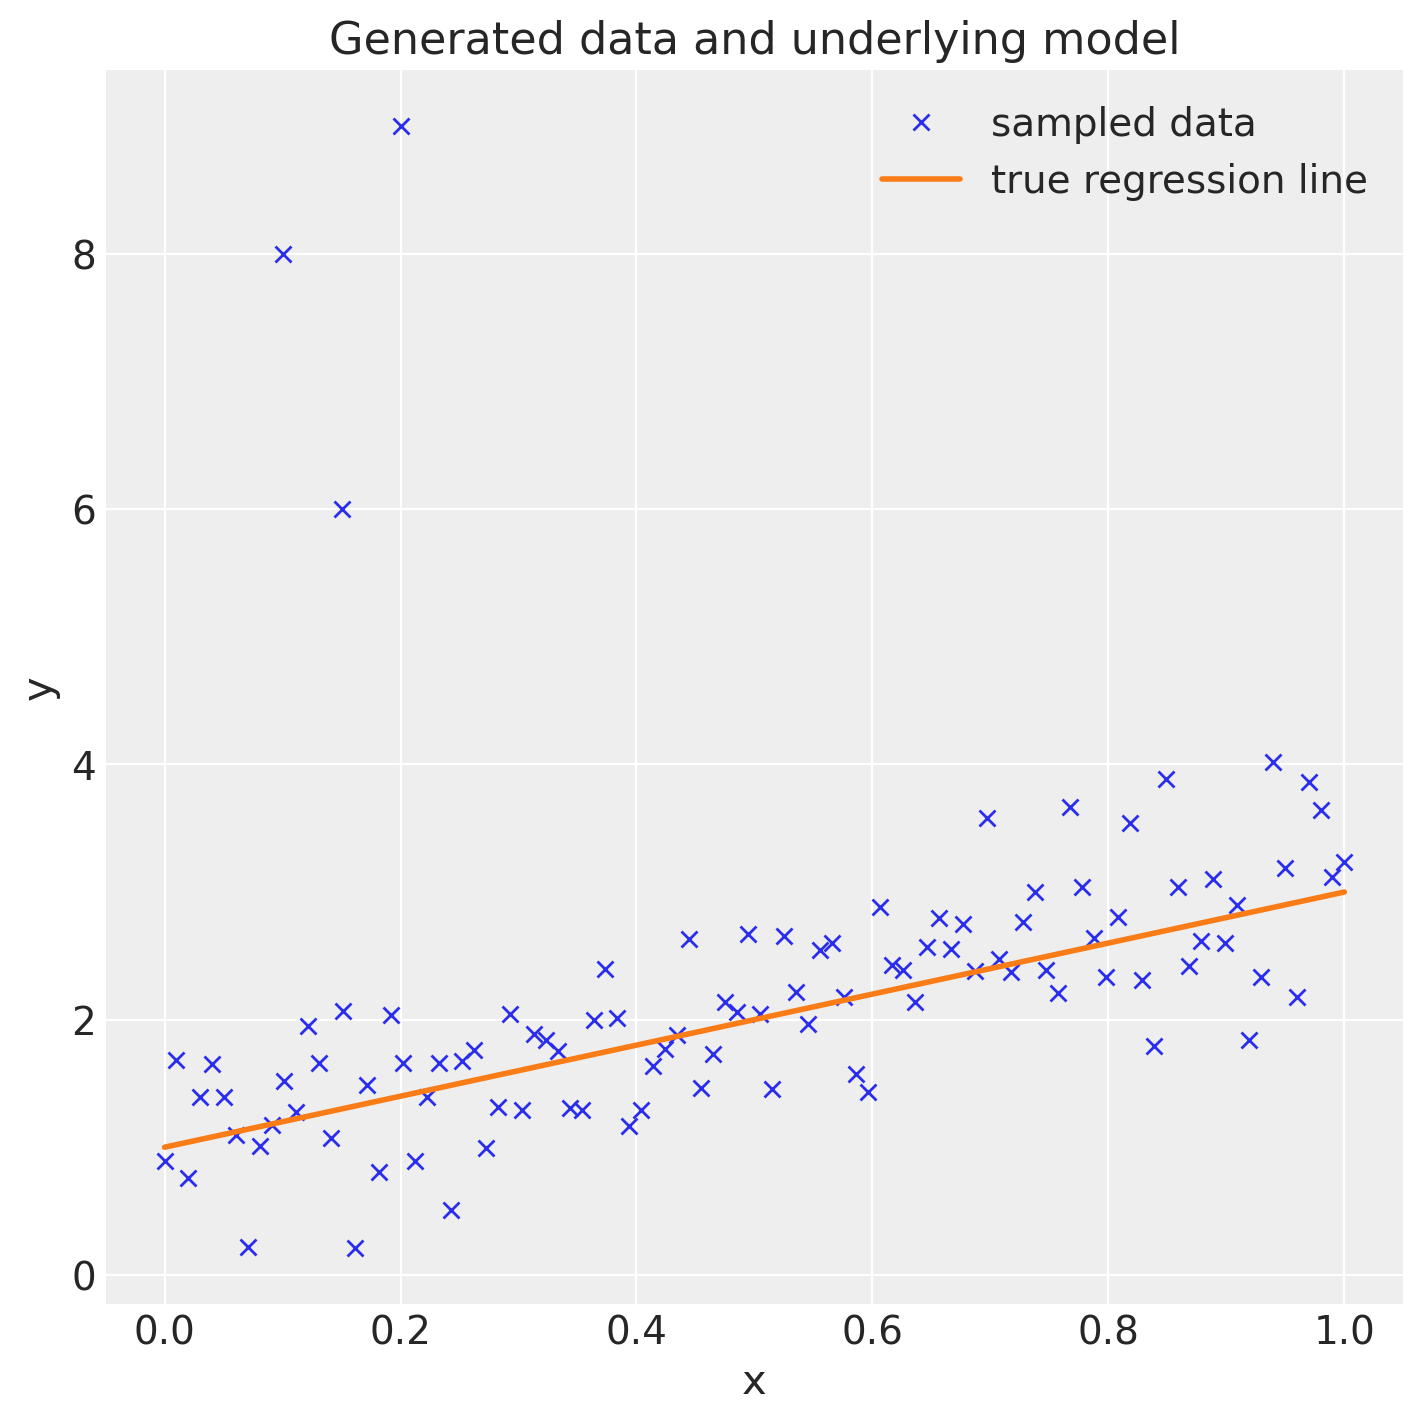

In [4]:
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, xlabel="x", ylabel="y", title="Generated data and underlying model")
ax.plot(x_out, y_out, "x", label="sampled data")
ax.plot(x, true_regression_line, label="true regression line", lw=2.0)
plt.legend(loc=0);

## Robust Regression

### Normal Likelihood

Lets see what happens if we estimate our Bayesian linear regression model by fitting a regression model with a normal likelihood. Note that the [`bambi`](https://bambinos.github.io/bambi/main/index.html) library provides an easy to use such that an equivalent model can be built using one line of code.

In [5]:
with pm.Model() as model:
    # define priors
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=1)
    sigma = pm.HalfCauchy("sigma", beta=10)
    
    mu = pm.Deterministic("mu", intercept + slope * x_out)

    # define likelihood 
    likelihood = pm.Normal("y", mu=mu, sigma=sigma, observed=y_out)
    
    # inference
    trace = pm.sample(tune=2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


/Users/conor/miniconda3/envs/pymc-dev-py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/conor/miniconda3/envs/pymc-dev-py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/conor/miniconda3/envs/pymc-dev-py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/conor/miniconda3/envs/pymc-dev-py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 10 seconds.


Using the posterior samples, we plot the <span style="color:purple">50%</span> and <span style="color:pink">95%</span> [*credible intervals*](https://en.wikipedia.org/wiki/Credible_interval) for the regression line with the normal likelihood.

Text(0.5, 1.0, 'Credible intervals for Normal likelihood')

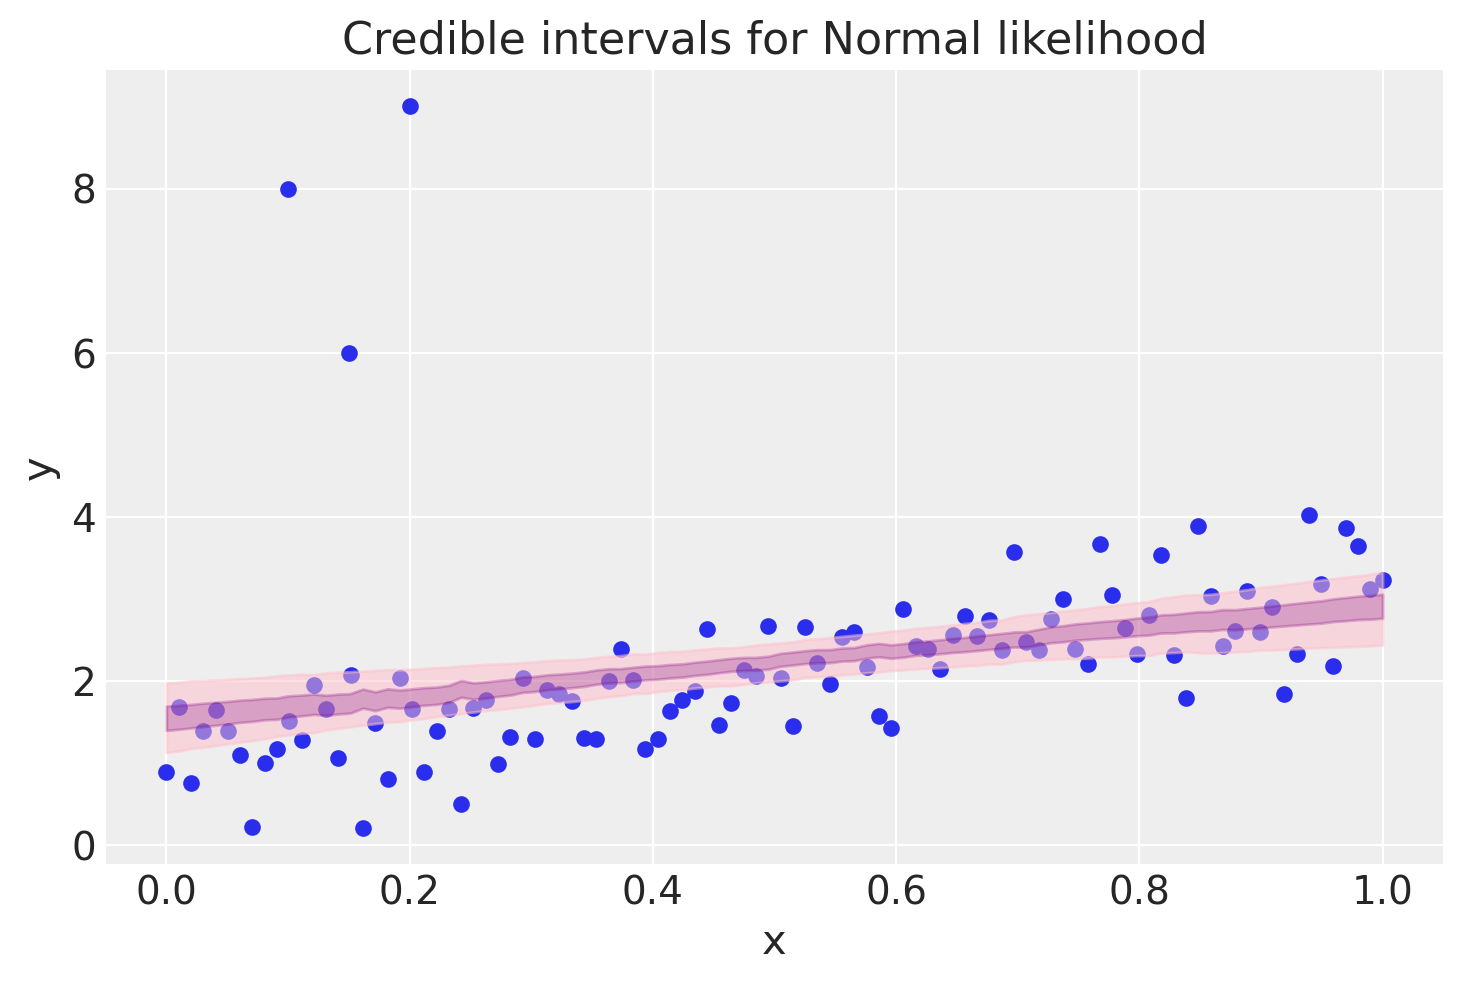

In [7]:
sc = plt.scatter(x_out, y_out, lw=0)
xi = xr.DataArray(x_out)
az.plot_hdi(
    xi,
    trace.posterior.mu,
    color="pink",
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.5},
    smooth=False,
)
az.plot_hdi(
    xi,
    trace.posterior.mu,
    color="purple",
    hdi_prob=0.5,
    fill_kwargs={"alpha": 0.25},
    smooth=False,
)
plt.ylabel("y")
plt.xlabel("x")
plt.title("Credible intervals for Normal likelihood")

We now want to generate from the [*posterior predictive*](https://en.wikipedia.org/wiki/Posterior_predictive_distribution) of the mean of the regression line `mu` at each of the observations `x`.

In [8]:
with model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=["mu"], random_seed=RANDOM_SEED)

Text(0.5, 1.0, 'Posterior predictive for normal likelihood')

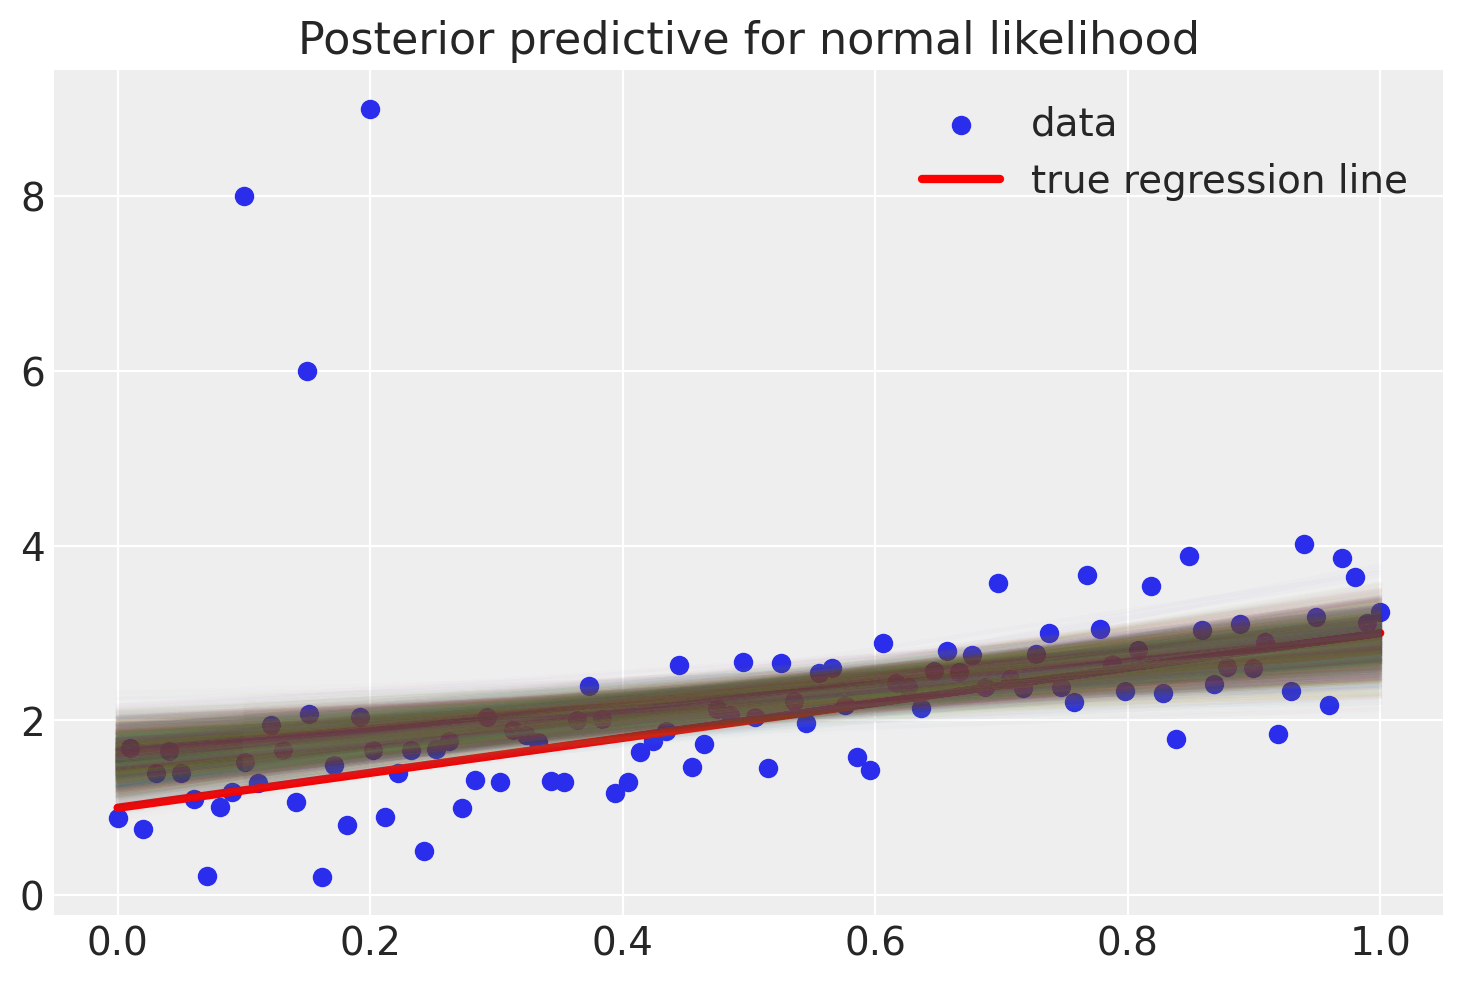

In [9]:
# 2-d nparray of posterior predictive samples
pp = posterior_predictive.posterior_predictive.mu.to_numpy().flatten().reshape(4000, len(x_out))

plt.scatter(x_out, y_out, label="data")
plt.plot(x, true_regression_line, label="true regression line", lw=3.0, c="r")
for i in range(0, 3999):
    plt.plot(x_out, pp[i], alpha=0.01)

plt.legend(loc=0)
plt.title("Posterior predictive for normal likelihood")

As you can see, the fit is quite skewed and we have a fair amount of uncertainty in our estimate as indicated by the wide range of different posterior predictive regression lines. Why is this? The reason is that the normal distribution does not have a lot of mass in the tails and consequently, an outlier will affect the fit strongly.

A Frequentist would estimate a [Robust Regression](http://en.wikipedia.org/wiki/Robust_regression) and use a non-quadratic distance measure to evaluate the fit.

But what's a Bayesian to do? Since the problem is the light tails of the Normal distribution we can instead assume that our data is not normally distributed but instead distributed according to the [Student T distribution](http://en.wikipedia.org/wiki/Student%27s_t-distribution) which has heavier tails as shown next (I read about this trick in ["The Kruschke"](http://www.indiana.edu/~kruschke/DoingBayesianDataAnalysis/), aka the puppy-book; but I think [Gelman](http://www.stat.columbia.edu/~gelman/book/) was the first to formulate this).

Lets look at those two distributions to get a feel for them.

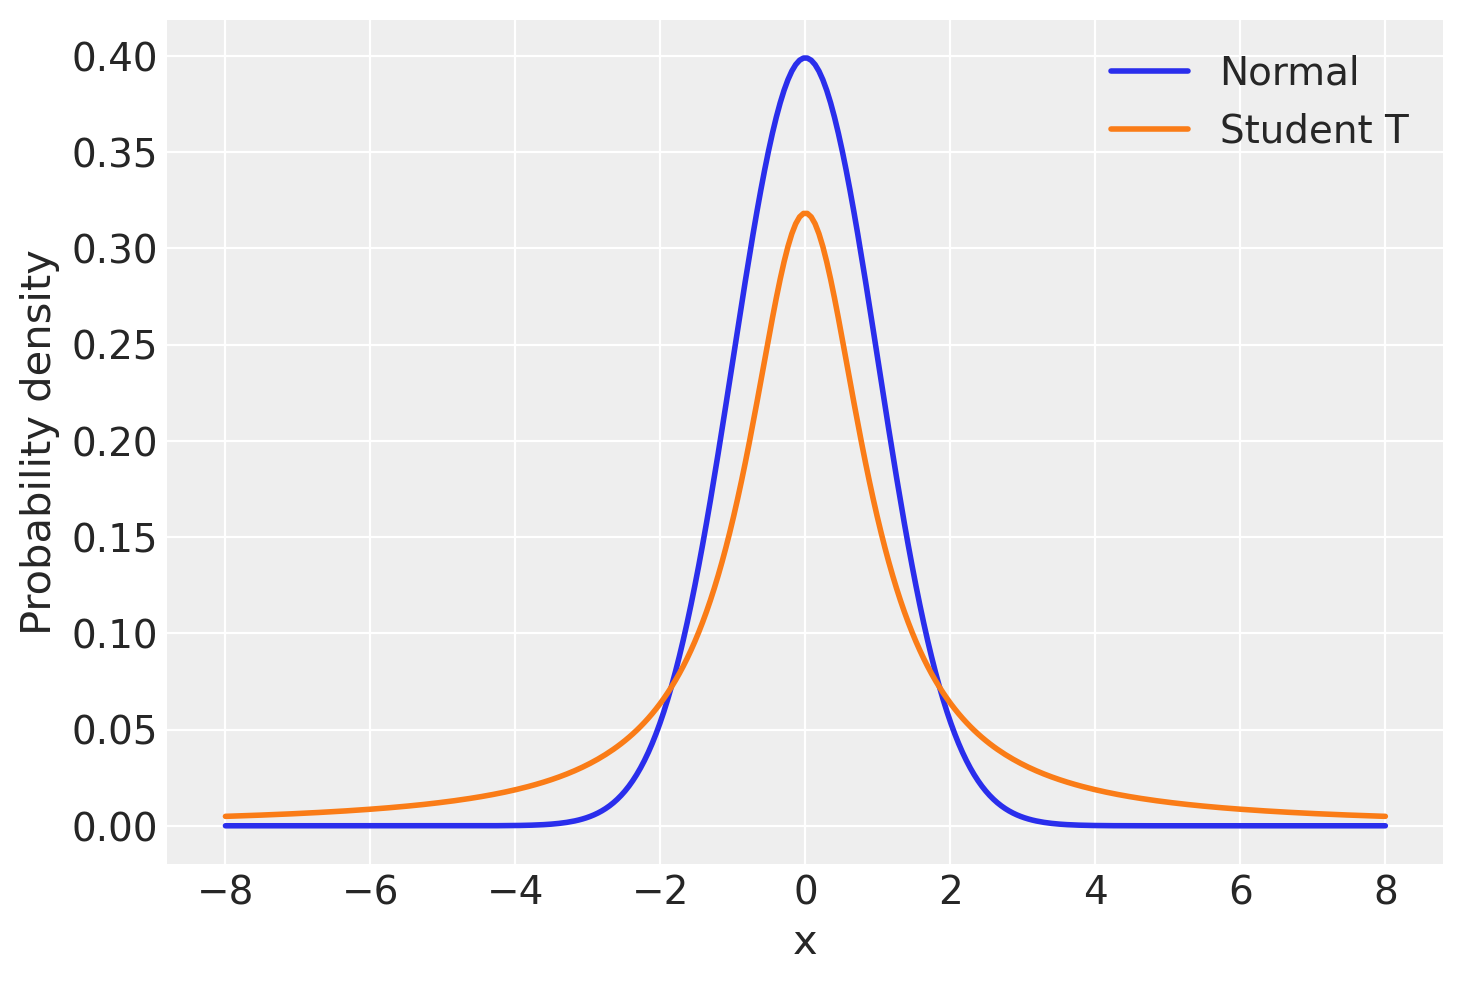

In [10]:
normal_dist = pm.Normal.dist(mu=0, sigma=1)
t_dist = pm.StudentT.dist(mu=0, lam=1, nu=1)
x_eval = np.linspace(-8, 8, 300)
plt.plot(x_eval, aesara.tensor.exp(pm.logp(normal_dist, x_eval)).eval(), label="Normal", lw=2.0)
plt.plot(x_eval, aesara.tensor.exp(pm.logp(t_dist, x_eval)).eval(), label="Student T", lw=2.0)
plt.xlabel("x")
plt.ylabel("Probability density")
plt.legend();

As you can see, the probability of values far away from the mean (0 in this case) are much more likely under the `T` distribution than under the Normal distribution.

Below is a PyMC model, with the `likelihood` term following a `StudentT` distribution with $\nu=1$ degrees of freedom, opposed to the `Normal` distribution.

In [11]:
with pm.Model() as robust_model:

    # define priors
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=1)
    sigma = pm.HalfCauchy("sigma", beta=10)

    mu = pm.Deterministic("mu", intercept + slope * x_out)

    # define likelihood 
    likelihood = pm.StudentT("y", mu=mu, sigma=sigma, nu=1, observed=y_out)
    
    # inference
    robust_trace = pm.sample(tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, sigma]


/Users/conor/miniconda3/envs/pymc-dev-py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/conor/miniconda3/envs/pymc-dev-py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/conor/miniconda3/envs/pymc-dev-py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
/Users/conor/miniconda3/envs/pymc-dev-py38/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:624: RuntimeWarning: overflow encountered in _beta_ppf
  return _boost._beta_ppf(q, a, b)
Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 10 seconds.
The acceptance probability does not match the target. It is 0.8815, but should be close to 0.8. Try to increase the

Using the posterior samples, we plot the <span style="color:purple">50%</span> and <span style="color:pink">95%</span> [*credible intervals*](https://en.wikipedia.org/wiki/Credible_interval) for the regression line with the student T likelihood.

Text(0.5, 1.0, 'Credible intervals for Student T likelihood')

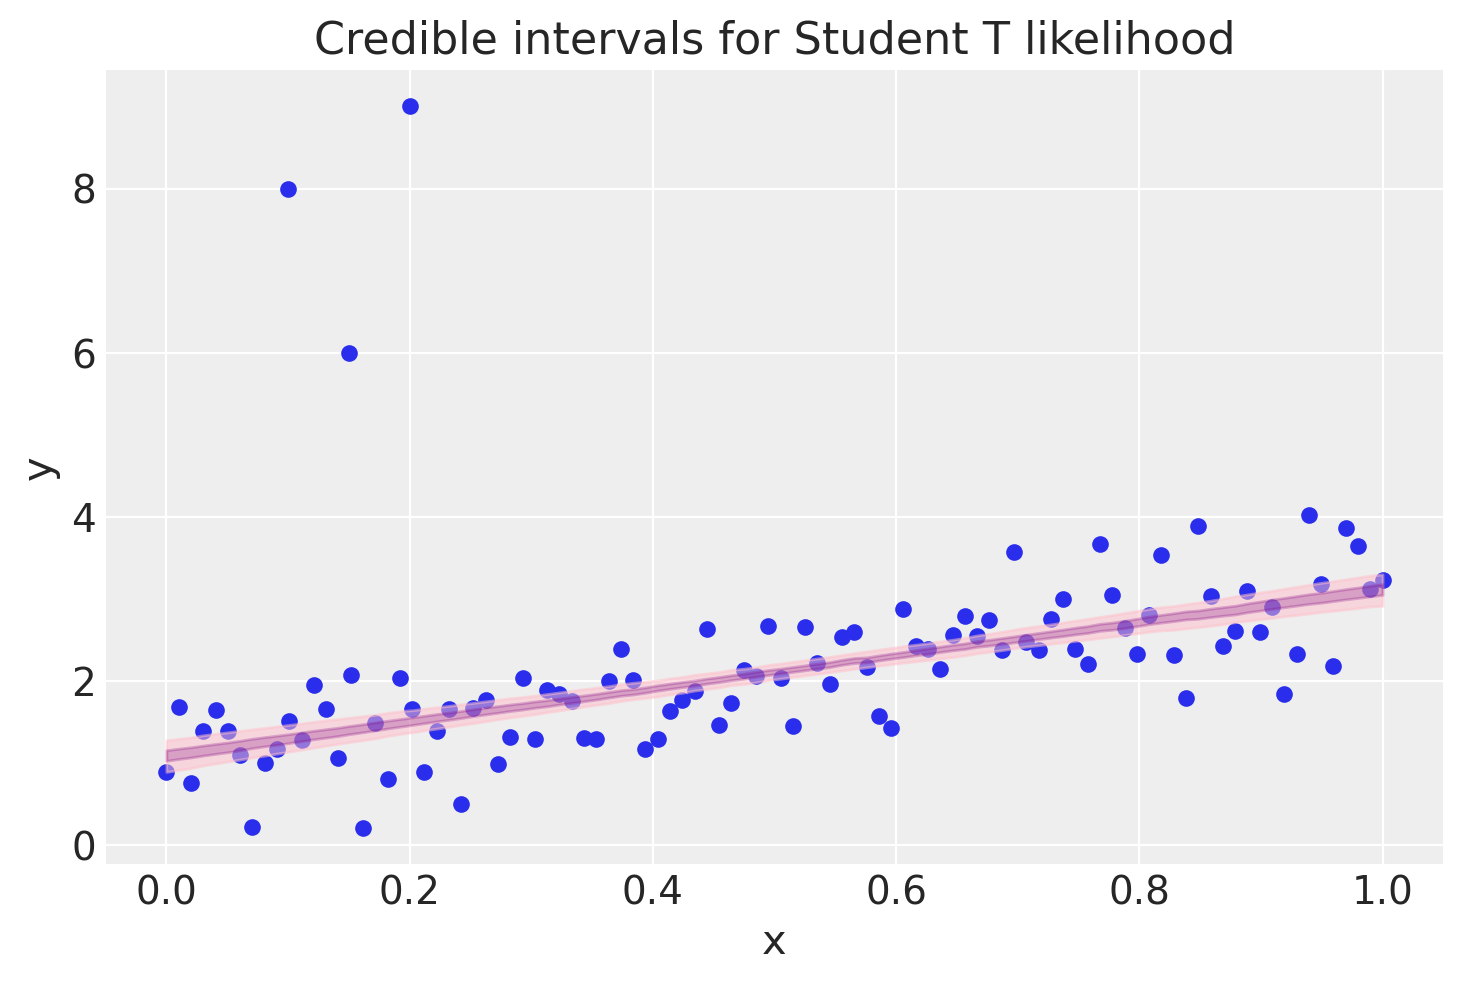

In [13]:
sc = plt.scatter(x_out, y_out, lw=0)
xi = xr.DataArray(x_out)
az.plot_hdi(
    xi,
    robust_trace.posterior.mu,
    color="pink",
    hdi_prob=0.95,
    fill_kwargs={"alpha": 0.5},
    smooth=False,
)
az.plot_hdi(
    xi,
    robust_trace.posterior.mu,
    color="purple",
    hdi_prob=0.5,
    fill_kwargs={"alpha": 0.25},
    smooth=False,
)

plt.ylabel("y")
plt.xlabel("x")
plt.title("Credible intervals for Student T likelihood")

In [14]:
with robust_model:
    robust_posterior_predictive = pm.sample_posterior_predictive(robust_trace, var_names=["mu"], random_seed=RANDOM_SEED)

Text(0.5, 1.0, 'Posterior predictive for Student-T likelihood')

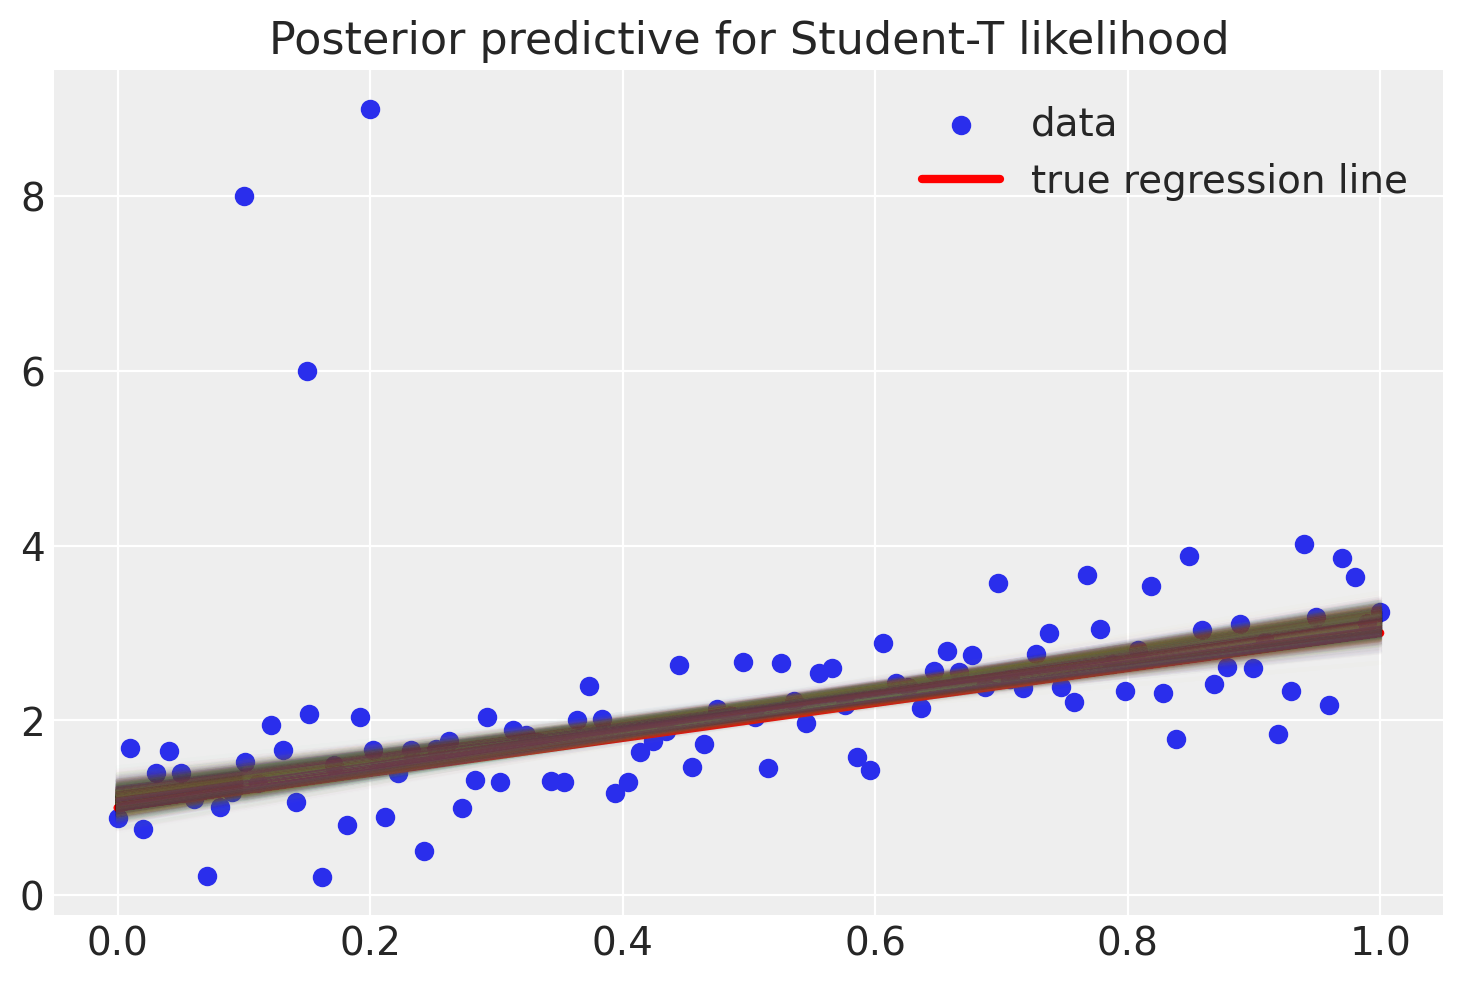

In [15]:
# 2d-nparray of posterior predictive samples
robust_pp = robust_posterior_predictive.posterior_predictive.mu.to_numpy().flatten().reshape(4000, len(x_out))

plt.scatter(x_out, y_out, label="data")
plt.plot(x, true_regression_line, label="true regression line", lw=3.0, c="r")
for i in range(0, 3999):
    plt.plot(x_out, robust_pp[i], alpha=0.01)

plt.legend(loc=0)
plt.title("Posterior predictive for Student-T likelihood")

There, much better! The outliers are barely influencing our estimation at all because our likelihood function assumes that outliers are much more probable than under the Normal distribution.

## Summary

 - By changing the likelihood from a Normal distribution to a Student T distribution -- which has more mass in the tails -- we can perform *Robust Regression*.

The next post will be about logistic regression in PyMC and what the posterior and oatmeal have in common.

*Extensions*: 

 - The Student-T distribution has, besides the mean and variance, a third parameter called *degrees of freedom* that describes how much mass should be put into the tails. Here it is set to 1 which gives maximum mass to the tails (setting this to infinity results in a Normal distribution!). One could easily place a prior on this rather than fixing it which I leave as an exercise for the reader ;).
 - T distributions can be used as priors as well. I will show this in a future post on hierarchical GLMs.
 - How do we test if our data is normal or violates that assumption in an important way? Check out this [great blog post](http://allendowney.blogspot.com/2013/08/are-my-data-normal.html) by Allen Downey. 

Author: [Thomas Wiecki](https://twitter.com/twiecki)

In [30]:
%load_ext watermark
%watermark -n -u -v -iv -w -p xarray

Last updated: Thu Jun 02 2022

Python implementation: CPython
Python version       : 3.8.13
IPython version      : 8.4.0

xarray: 2022.3.0

aesara    : 2.6.2
xarray    : 2022.3.0
arviz     : 0.12.1
matplotlib: 3.5.2
numpy     : 1.22.4
sys       : 3.8.13 | packaged by conda-forge | (default, Mar 25 2022, 06:04:14) 
[Clang 12.0.1 ]
pandas    : 1.4.2
pymc      : 4.0.0b6

Watermark: 2.3.1

